# Gaussian Mixture Models

In this notebook, we delve into the fascinating world of probabilistic modeling. Utilizing a two-component Gaussian Mixture Model (GMM), we will employ the Expectation-Maximization (EM) algorithm to optimize our model's parameters to separate the alpah-rich and $\alpha$-normal disk of the Milky Way.

Before diving into this notebook, you should already have some familiarity with Gaussian Mixture Models and the Expectation-Maximization algorithm. These are fundamental techniques in statistical modeling and machine learning for clustering, density estimation, and exploratory data analysis. Typically, GMMs provide a way to model data as a combination of multiple Gaussian distributions, while the EM algorithm iteratively optimizes the parameters of these distributions.

#### Learning Outcomes

- **Modelling Data with a Gaussian Mixture Model**:
Upon completing this notebook, you should be well-equipped to apply Gaussian Mixture Models to various types of data. Not only will you learn how to fit the model, but you'll also understand how to interpret the Gaussian components and their relevance in the context of the dataset.

- **Understanding Why and How This Model is an Instance of EM**:
One of the key objectives of this notebook is to deepen your understanding of the Expectation-Maximization algorithm within the context of GMMs. You will learn how the E-step and M-step operate in tandem to estimate the model parameters, and why this process is essential for GMMs.

- **Visualising the Convergence of the Gaussian Mixture Model Algorithm**:
Visual representation can be a powerful tool in understanding algorithmic behavior. In this notebook, you will learn techniques for plotting the progress of your GMM as it iterates through the EM steps. This will help you gain insights into the speed of convergence and the stability of your model, as well as providing a compelling way to demonstrate your results.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import chi2
from matplotlib.patches import Ellipse

## Recap of Gaussian Mixture Models

Gaussian Mixture Models (GMMs) offer a robust approach to model complex data distributions. When given a dataset $\{\mathbf{x}_1, \ldots, \mathbf{x}_n \}$ with each $\mathbf{x}_i \in \mathbb{R}^D$, GMMs postulate that this data is generated from a sum of $K$ different Gaussian distributions. Mathematically, the probability distribution $p$ is defined as:

$$
p(\mathbf{x}) := \sum_{k=1}^K \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k )
$$

Here, $\pi_k$ are the mixture weights, and $\mathcal{N}(x \mid \mu_k, \Sigma_k )$ are the individual Gaussian distributions characterized by means $\mu_k$ and covariances $\Sigma_k$. The mixture weights must satisfy the constraint:

$$
\sum_{k=1}^K \pi_k = 1
$$

### How Sampling Works

To clarify how a point is sampled from $p(\mathbf{x})$, imagine drawing a random number $p$ uniformly from the interval $[0,1)$. Based on the value of $p$, we determine which Gaussian distribution to sample from. For example, if $p$ lies in the range $[\sum_{i=1}^{k-1} \pi_i, \sum_{i=1}^{k} \pi_k)$, we sample $\mathbf{x}$ from $\mathcal{N}(x \mid \mu_k, \Sigma_k )$.

### Log-Likelihood Function

The log-likelihood function for GMMs is expressed as:

$$
\log p(\mathbf{x} \mid \pi, \mu, \Sigma) 
= \sum_{n=1}^N \log \{ \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} \mid \mu_k, \Sigma_k) \}
$$

The goal is to find $\pi$, $\mu$, and $\Sigma$ that maximize this function. However, this is easier said than done due to the complex inter-dependencies between these parameters.

### Maximizing Log-Likelihood Through EM Algorithm

#### Responsibilities and Effective Number of Points

We introduce a variable called the 'responsibility', denoted by $\gamma_{nk}$, which essentially quantifies the likelihood that the $n^{th}$ data point is generated by the $k^{th}$ Gaussian. It is computed as:

$$
\gamma_{nk} = \frac{\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k ) }
    { \sum_{k=1}^K \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)}
$$

We then define $N_k$, the effective number of points for the $k^{th}$ Gaussian, as:

$$
N_k := \sum_{n=1}^N \gamma_{nk}
$$

#### EM Algorithm Steps

The Expectation-Maximization (EM) algorithm proceeds in a series of steps to iteratively update the model parameters and maximize the log-likelihood.

- **Step 1 (Initialization)**: Choose initial values for $\mu_k, \Sigma_k, \pi_k$, and calculate the initial log-likelihood.

- **Step 2 (Expectation)**: Compute the responsibilities using the current parameters.

- **Step 3 (Maximization)**: Update the parameters based on the newly computed responsibilities:

$$
N_k^\mathrm{new} \equiv \sum_{n=1}^N \gamma_{nk} 
$$

$$
\pi_k^{\mathrm{new}} \equiv \frac{N_k^\mathrm{new}}{N} 
$$

$$
\mu_k^\mathrm{new} \equiv \dfrac{1}{N_k^\mathrm{new}} \sum_{n=1}^N \gamma_{nk} \mathbf{x}_n 
$$

$$
\Sigma_k^\mathrm{new} \equiv \dfrac{1}{N_k^\mathrm{new}} \sum_{n=1}^N \gamma_{nk} (\mathbf{x}_n - \mu_k^\mathrm{new}) (\mathbf{x}_n - \mu_k^\mathrm{new})^T
$$


- **Step 4 (Evaluate)**: Calculate the new log-likelihood. If it hasn't converged, return to Step 2.

By iteratively applying these steps, the EM algorithm arrives at an optimized set of parameters that maximize the log-likelihood.

#### Summary of Variables

Here is a handy table summarizing the various variables involved:


| Variable |     Type   |  Description| Known? |
|---|---|---|---|
| $$N$$ 			 |   $$\mathbb{N}$$ | Number of data points | Yes |
| $$D$$ 				| $$\mathbb{N}$$				| Dimension of data points | Yes |
| $$K$$				| $$\mathbb{N}$$				| Number of gaussians | Yes |
| $$\mathbf{x}_n$$ | $$\mathbb{R}^D$$ 	| A data point | Yes |
| $$X$$            | $$\mathbb{R}^{N \times D}$$ 	| Data matrix | Yes |
| $$\gamma_{nk}$$ | $$\mathbb{R}$$ | The responsibility for the $k$ component to explain the observation $\mathbb{x}_n$. | No|
| $$N_k$$ | $$\mathbb{N}$$ | The effective number of points assigned to the $k^\mathrm{th}$ gaussian. | No | 
| $$\pi_k$$ 		| $$\mathbb{R}$$ 			    | The mixture weighting on the $k^\mathrm{th}$ gaussian. | No |
| $$\mu_k$$ 		| $$\mathbb{R}^D$$ 			| The mean of the $k^\mathrm{th}$ gaussian. | No |
| $$\Sigma_k$$ 	| $$\mathbb{R}^{D \times D}$$ | The covariance of the $k^\mathrm{th}$ gaussian. | No |
| $$\pi$$ | $$\mathbb{R}^{K}$$ | A vector of all the gaussian mixture weightings $\pi_1, \ldots, \pi_K$. | No|
| $$\mu$$ | $$\mathbb{R}^{K \times D}$$ | A matrix of all the gaussian means $\mu_1, \ldots, \mu_K$. | No |
| $$\Sigma$$ | $$\mathbb{R}^{K \times D \times D}$$ | A 3-tensor of all the gaussian covariances $\Sigma_1, \ldots, \Sigma_K$. | No|

## The Dataset 

In this study, we aim to differentiate between two specific stellar populations in the Milky Way galaxy: the $\alpha$-rich and $\alpha$-normal disk stars. 

For many years, astronomers have observed a unique bimodal distribution when mapping out the elemental abundances of Milky Way stars. Specifically, one group of stars is enriched in what are known as $\alpha$ elements (such as Oxygen, Magnesium, Silicon, etc.), particularly when compared to elements like iron (Fe).

$\alpha$ elements are so-called because they are primarily formed by the capture of $\alpha$ particles (Helium-4 nuclei) during nuclear synthesis processes. This usually occurs in the extreme conditions of core-collapse supernovae—massive explosions marking the end of a star's life cycle. 

The population that is $\alpha$-enriched is believed to belong to an older generation within the Milky Way. The reasoning behind this lies in the galaxy's evolutionary history.

#### Galactic Evolution and Type Ia Supernovae

As the galaxy ages, other types of supernovae, particularly Type Ia supernovae, begin to play a role in elemental formation. Unlike core-collapse supernovae, which are prolific creators of $\alpha$ elements, Type Ia supernovae primarily produce elements near the iron peak in the periodic table (such as iron itself). Over time, the increased contribution of Type Ia supernovae dilutes the $\alpha$-to-iron ratio in newly formed stars, leading to what we categorize as the $\alpha$-normal population.

Our primary goal is to segregate these two chemically distinct populations effectively. To achieve this, we plan to employ a Gaussian Mixture Model (GMM) as a tool for statistical analysis and classification. This machine learning approach allows us to model the complex, bimodal distribution of elemental abundances and thereby gain valuable insights into the stellar populations of our galaxy.


Text(0, 0.5, '[Mg/Fe]')

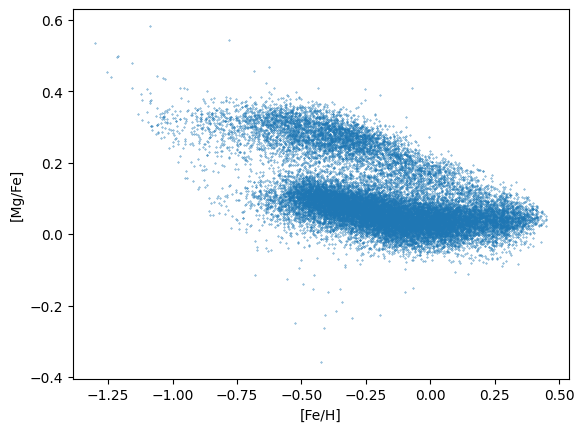

In [2]:
# load data
data = np.load("apogee_sample_tutorial_week8b.npz")
feh = data["feh"]
mgfe = data["mgfe"]

data = np.vstack([feh, mgfe]).T
data_labels = ["[Fe/H]", "[Mg/Fe]"]

# plot data
plt.scatter(feh, mgfe, s=0.1)

plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")

## Initializing Gaussian Mixture Model Parameters

Before running the Gaussian Mixture Model (GMM) on our dataset, it's crucial to set initial values for the model's parameters. These initializations guide the iterative process of the Expectation-Maximization (EM) algorithm, which we will be using to optimize the model. For our problem, we'll use a two-component Gaussian Mixture Model to capture the bimodal distribution of alpha-enriched and alpha-normal stars.

#### Initial Means: $ \mu_0 $

We will initialize the means of our two Gaussian components as follows:

- For the first Gaussian ($ \mu_1 $):
$$
\begin{bmatrix}
    -1 \\
    +1
\end{bmatrix}
$$

- For the second Gaussian ($ \mu_2 $):
$$
\begin{bmatrix}
    +1 \\
    -1
\end{bmatrix}
$$

#### Initial Covariance Matrices: $ \Sigma_0 $

Both covariance matrices will be initialized as identity matrices. This assumes, initially, that the features are uncorrelated and have a unit variance.

#### Initial Mixture Weights: $ \pi_0 $

Initially, we will assume that both Gaussian components are equally likely to generate any given data point. Thus, the initial mixture weights will be equal; specifically, each will be set to 0.5.

#### Summary of Initial Parameters

- `mu_0`: A $2 \times 2$ matrix containing the initial means of the Gaussians.
  - $\mu_0 = [ \begin{array}{cc} -1 & 1 \\ 1 & -1 \end{array} ]$

- `Sigma_0`: A $2 \times 2 \times 2$ 3-tensor containing the initial covariance matrices.
  - $\Sigma_0 = [ \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array} ] \times 2$

- `pi_0`: A vector containing the initial mixture weights.
  - $\pi_0 = [ 0.5, 0.5 ]$

By initializing these parameters, we can now proceed with the EM algorithm to fit the Gaussian Mixture Model to our dataset.

In [3]:
# Solution
pi_0 = np.array([0.5,0.5])
mu_0 = np.array([[-1.0,1.0],[1.0,-1.0]])
Sigma_0 = np.array([ [[1.0,0.0],[0.0,1.0]] , [[1.0,0.0],[0.0,1.0]]])

## Visualizing the Data and Gaussian Components

To better understand the Expectation-Maximization (EM) process and the distribution of our data, we will plot both the data points and ellipses representing our Gaussian components. The ellipses will provide a visual interpretation of the covariance and mean of each Gaussian in our mixture model.

### Helper Functions for Plotting

Below are some Python functions that facilitate the plotting.

#### plot_cov_ellipse Function

The `plot_cov_ellipse` function plots an ellipse based on a given 2x2 covariance matrix and a location for the ellipse's center. The function also allows the customization of the ellipse's appearance through various parameters.

- `cov`: The 2x2 covariance matrix to base the ellipse on.
- `pos`: The location of the center of the ellipse.
- `volume`: The volume inside the ellipse; default is 0.5.
- `ax`: The axis to plot the ellipse on; defaults to the current axis.

#### plot_components Function

The `plot_components` function uses `plot_cov_ellipse` to plot ellipses for each Gaussian component in our mixture model. It takes in the means (`mu`) and covariances (`Sigma`) of each Gaussian, along with their respective colors, to render these ellipses on the plot.

#### plot_data Function

The `plot_data` function plots the actual data points. Optionally, it can color the points based on a 'redness' value, allowing us to visually separate data that might belong to different components of the Gaussian mixture.

These helper functions will enable us to visualize the Gaussian components and their evolution as we proceed with the EM algorithm.

In [4]:
# plot_cov_ellipse was taken from here:
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/

def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    

def plot_components(mu, Sigma, colours, *args, **kwargs):
    """
    Plot ellipses for the bivariate normals with mean mu[:,i] and covariance Sigma[:,:,i]
    """
    assert mu.shape[1] == Sigma.shape[2]
    assert mu.shape[0] == 2
    assert Sigma.shape[0] == 2
    assert Sigma.shape[1] == 2
    for i in range(mu.shape[1]):
        kwargs['ec'] = colours[i]
        plot_cov_ellipse(Sigma[i], mu[i], *args, **kwargs)

br_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

def plot_data(redness=None):
    fig, ax = plt.subplots(figsize=(8,8))

    if redness is not None:
        assert len(redness) == data.shape[0]
        assert all(_ >= 0 and _ <= 1 for _ in redness)
        c = redness
        plt.scatter(data[:,0],data[:,1], marker='.', s=0.1, alpha=0.3, linewidths=2, c=c, cmap=br_cmap)
    else:
        c = 'g'
        plt.scatter(data[:,0],data[:,1], marker='.', s=0.1, alpha=0.3, linewidths=2, c=c)
    
    plt.xlabel(data_labels[0])
    plt.ylabel(data_labels[1])
    plt.axis([-2,2,-2,2])
    plt.axis('equal')

    return fig, ax


In the next code cell, we demonstrate how to utilize the plotting functions we've defined earlier. We'll plot the dataset along with the initial guesses for our Gaussian components. This visualization will help us understand our starting point before we begin iterating with the Expectation-Maximization algorithm.

The code will only execute if the required variables (`mu_0`, `Sigma_0`, and `data`) have been previously defined. If these variables are in place, the function `plot_data()` will plot the data points, and `plot_components()` will overlay the initial Gaussian ellipses on the same plot.

This plot will serve as a reference point, helping us to evaluate how well our Gaussian Mixture Model fits the data as we proceed with the EM algorithm.

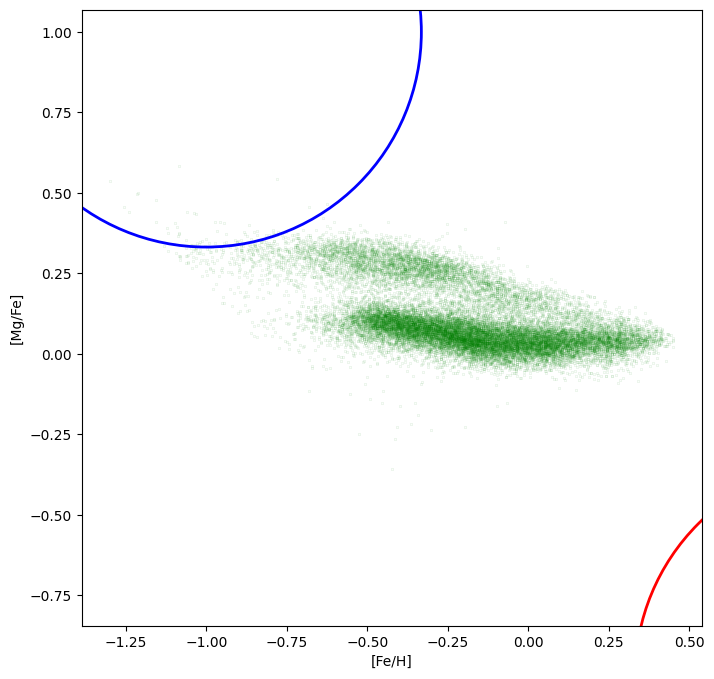

In [5]:
# Check if the required variables are defined
if 'mu_0' in locals() and 'Sigma_0' in locals() and 'data' in locals():
    # Plot the data points
    fig, ax = plot_data()
    
    # Plot the initial Gaussian components
    plot_components(mu_0, Sigma_0, ['b', 'r'], 0.2, ax=ax)

    # Display the plot
    plt.show()

## Optimizing the Gaussian Mixture Model with EM

As discussed in lectures, the Gaussian Mixture Model (GMM) can be optimized using the Expectation-Maximization (EM) algorithm. This technique allows for the maximum likelihood estimation of the model parameters $\mathbf{\mu}$, $\mathbf{\Sigma}$, and $\mathbf{\pi}$.

#### Function Signatures

The primary functions involved in this algorithm are the E-step and the M-step. The suggested function signatures are as follows:

- For the E-step: 
```python
def e_step(X, mu, Sigma, pi):
```

- For the M-step:
```python
def m_step(X, gamma):
```

#### Helper Functions

In addition to these, a helper function named `weighted_normals` is used to calculate an $ N \times K $ matrix of weighted normal probabilities, i.e., $ \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k) $.

The function signature for the helper function is:

```python
def weighted_normals(X, mu, Sigma, pi):
```

#### Tips

You can make use of the `scipy.stats` library to compute the multivariate normal distribution probabilities:

```python
from scipy.stats import multivariate_normal as mvnorm
```

You can use `mvnorm.pdf(x, mu, sigma)` to compute $ \mathcal{N}(\mathbf{x}_N \mid \mu_k, \Sigma_k) $.


In [6]:
def weighted_normals(X, mu, Sigma, pi):
    """
    Calculates the numerator of the gamma_i's, i.e., the 
    weighted normal probabilities for each data point.
    """
    N, D = X.shape
    K, = pi.shape
    w_norms = np.zeros((N,K)) # (N,K)
    for k in range(K):
        w_norms[:,k] = pi[k] * mvnorm.pdf(X, mu[k], Sigma[k]) # (N,)
    return w_norms # (N,K)

def e_step(X, mu, Sigma, pi):
    """
    Performs the E-step of the EM algorithm.
    """
    w_norms = weighted_normals(X, mu, Sigma, pi)
    gamma = w_norms / np.sum(w_norms, axis=1, keepdims=True)
    return gamma

def m_step(X, gamma):
    """
    Performs the M-step of the EM algorithm.
    """
    N,D = X.shape
    _, K = gamma.shape
    Nk = gamma.sum(axis=0) # (N,K)=>(K,)
    new_pi = Nk / N # (K,)

    new_mu = gamma.T @ X # (K,N)@(N,D) => (K,D)
    new_mu /= Nk.reshape(-1,1) # (K,D) / (K,1) => (K,D)

    diff = X.reshape(N,1,D) - new_mu.reshape(1,K,D) # (N,1,D) - (1,K,D) => (N,K,D)
    scaled_diff = gamma.reshape(N,K,1) * diff # (N,K,1) * (N,K,D) => (N,K,D)
    new_Sigma = scaled_diff.transpose((1,2,0)) @ diff.transpose(1,0,2) # (K,D,N) @ (K,N,D) => (K,D,D)
    new_Sigma /= Nk.reshape(-1,1,1)  # (K,D,D) / (K,1,1) = (K,D,D)

    return new_mu, new_Sigma, new_pi # (K,D), (K,D,D), (K,)



### Evaluating the Model

To evaluate the performance of the Gaussian Mixture Model, we will calculate its log-likelihood for given parameters $ \mathbf{\mu} $, $ \mathbf{\Sigma} $, and $\mathbf{\pi}$.

The function computes the log-likelihood by first obtaining the weighted normal probabilities using the `weighted_normals` function. Then it sums up the log of these probabilities across all data points. The resulting value will be a single scalar that measures how well the given parameters $ \mathbf{\mu} $, $ \mathbf{\Sigma} $, and $ \mathbf{\pi} $ fit the data $ \mathbf{X} $.


In [7]:
def log_likelihood(X, mu, Sigma, pi):
    # Calls the helper function to get the weighted normal probabilities
    w = weighted_normals(X, mu, Sigma, pi)
    
    # Computes the log-likelihood using the obtained probabilities
    ll = np.log(w.sum(axis=1)).sum()
    
    return ll

An essential aspect of any iterative algorithm, like the EM algorithm, is to check if it converges. For this purpose, we can plot the log-likelihood of the model against the number of updates made to it.

The idea is to run the EM algorithm for a fixed number of trials and calculate the log-likelihood at each step. We will then visualize this information to assess the convergence of the model.



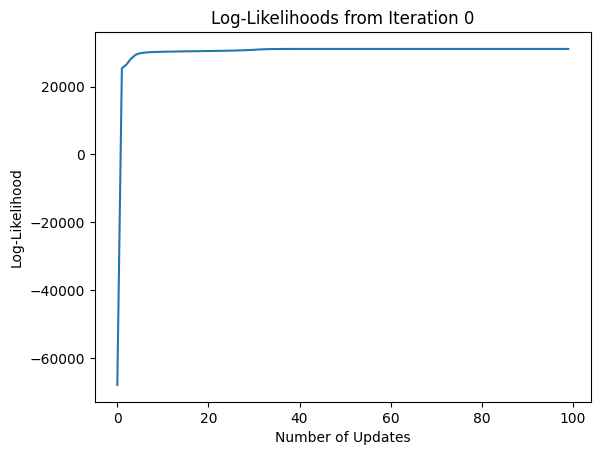

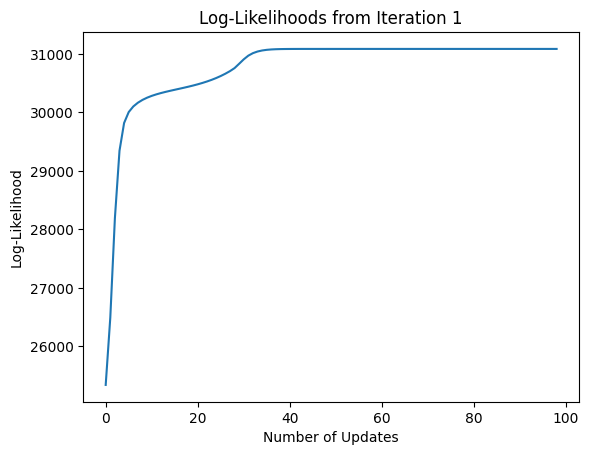

In [8]:
# Initialize parameters
mu = mu_0
Sigma = Sigma_0
pi = pi_0

# Number of trials
trials = 100

# Array to hold the log-likelihoods
ll = np.zeros(trials)

# Run the EM algorithm
for i in range(0, trials):
    ll[i] = log_likelihood(data, mu, Sigma, pi)
    gamma = e_step(data, mu, Sigma, pi)
    (mu, Sigma, pi) = m_step(data, gamma)

# Plotting the log-likelihoods from iteration 0
plt.figure()
plt.title("Log-Likelihoods from Iteration 0")
plt.xlabel("Number of Updates")
plt.ylabel("Log-Likelihood")
plt.plot(ll)
plt.show()

# Plotting the log-likelihoods starting from iteration 1
plt.figure()
plt.title("Log-Likelihoods from Iteration 1")
plt.xlabel("Number of Updates")
plt.ylabel("Log-Likelihood")
plt.plot(ll[1:])
plt.show()

### Visualising EM

Use the functions `plot_data` and `plot_components` to visualize the data points and your current Gaussian mixture model at different stages of the algorithm.



Iteration 0: Current Log-Likelihood = -67924.9713201784


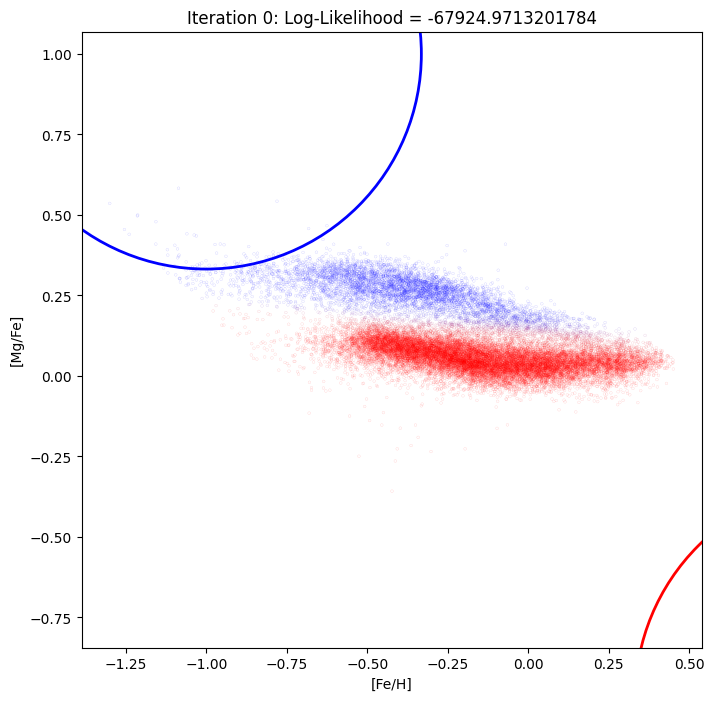

Iteration 5: Current Log-Likelihood = 29819.596660256437


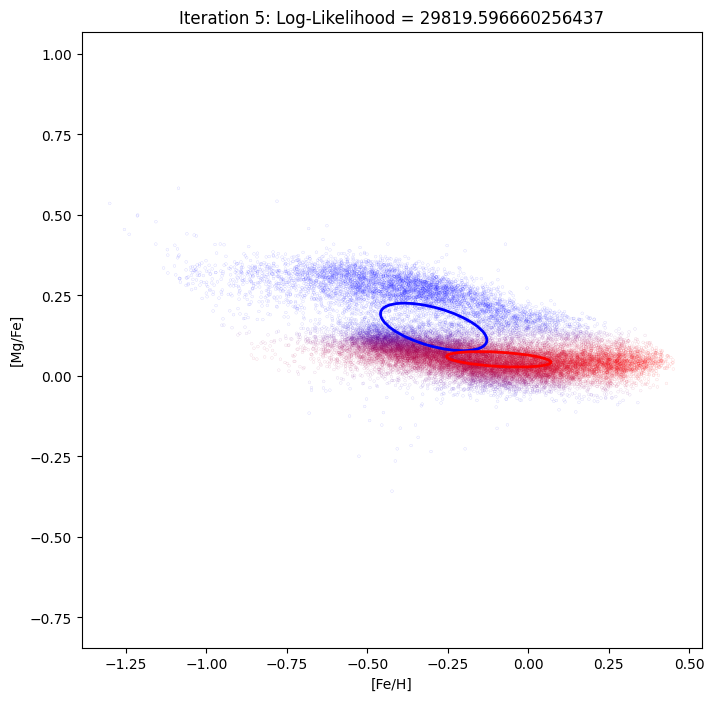

Iteration 10: Current Log-Likelihood = 30252.041339475916


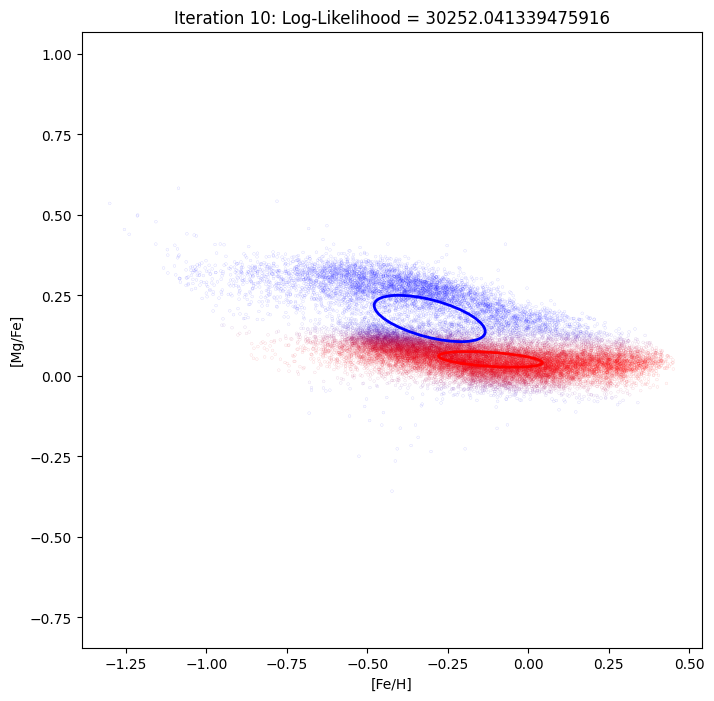

Iteration 15: Current Log-Likelihood = 30369.4893634923


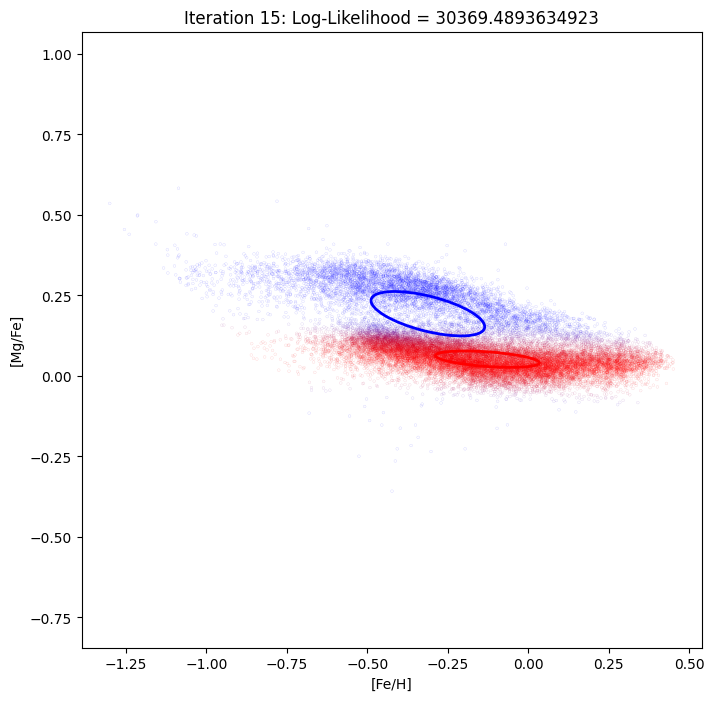

Iteration 20: Current Log-Likelihood = 30459.84457905654


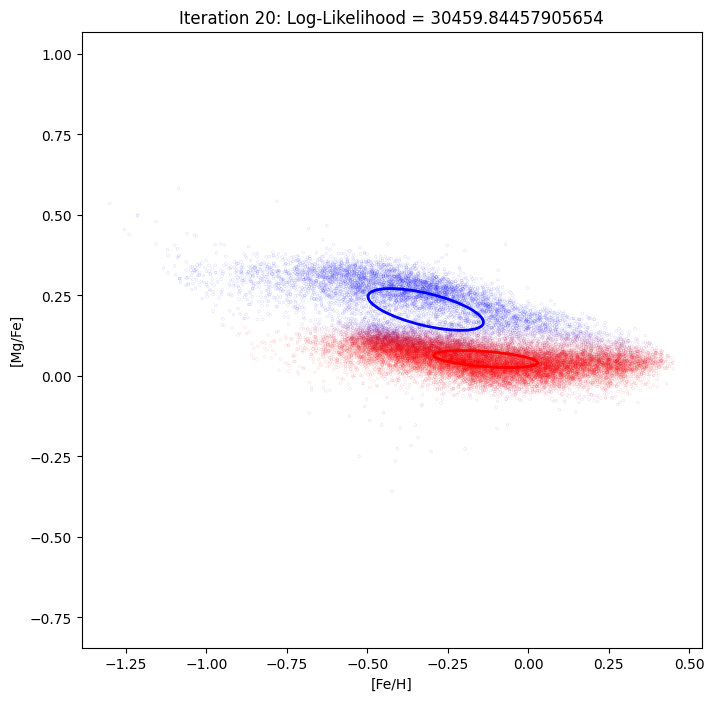

Iteration 25: Current Log-Likelihood = 30587.55628372154


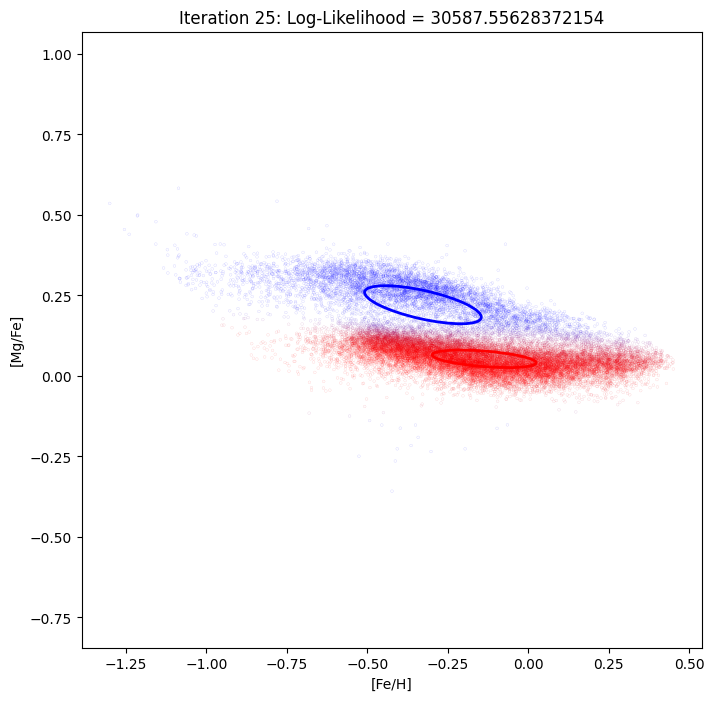

Iteration 30: Current Log-Likelihood = 30831.68840373552


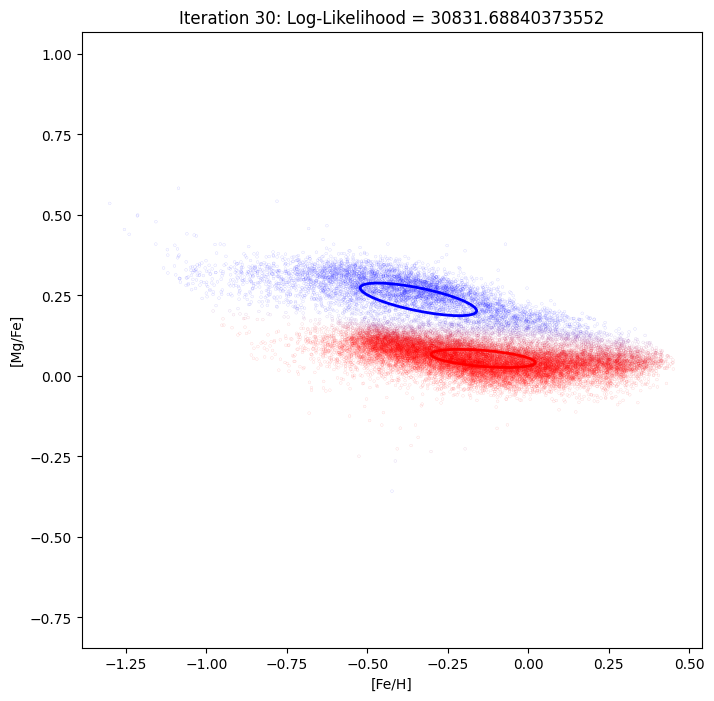

Iteration 35: Current Log-Likelihood = 31059.01737474901


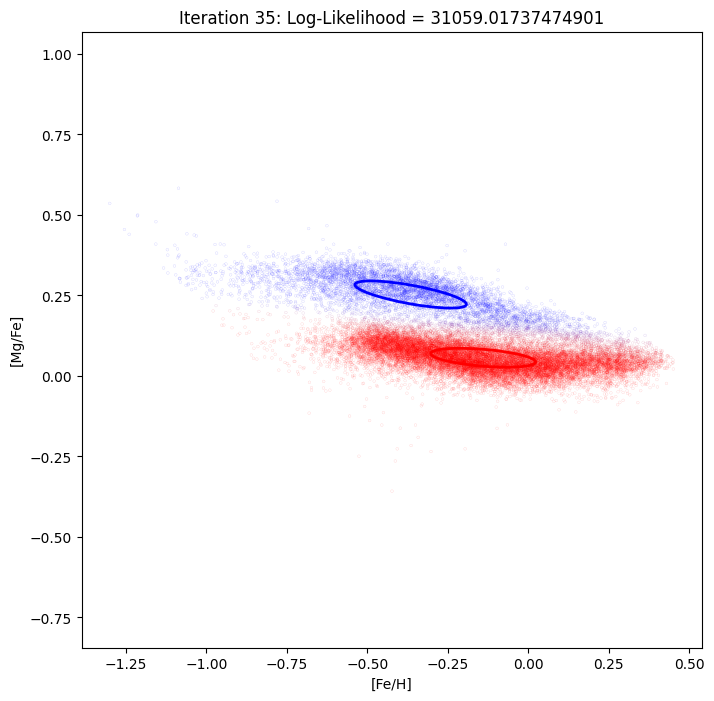

Iteration 40: Current Log-Likelihood = 31084.115874968666


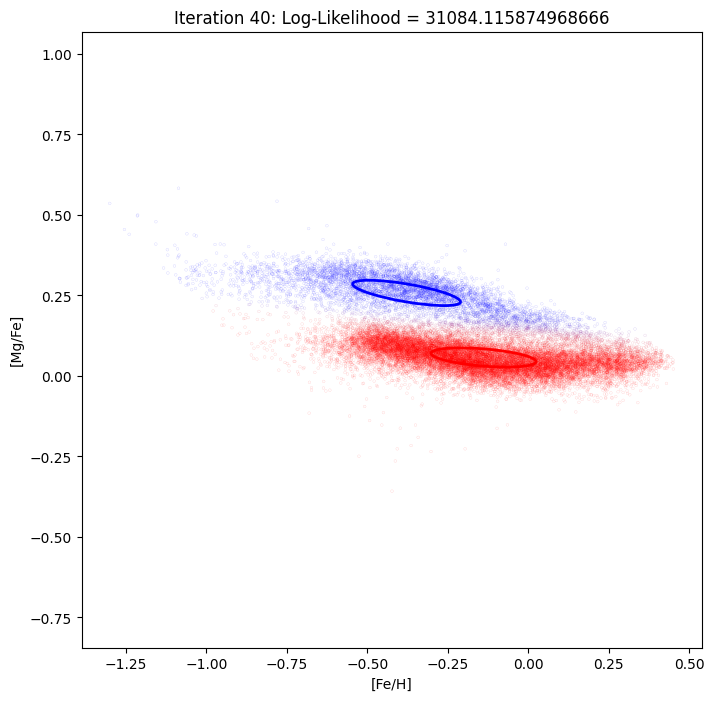

Iteration 45: Current Log-Likelihood = 31085.570562996236


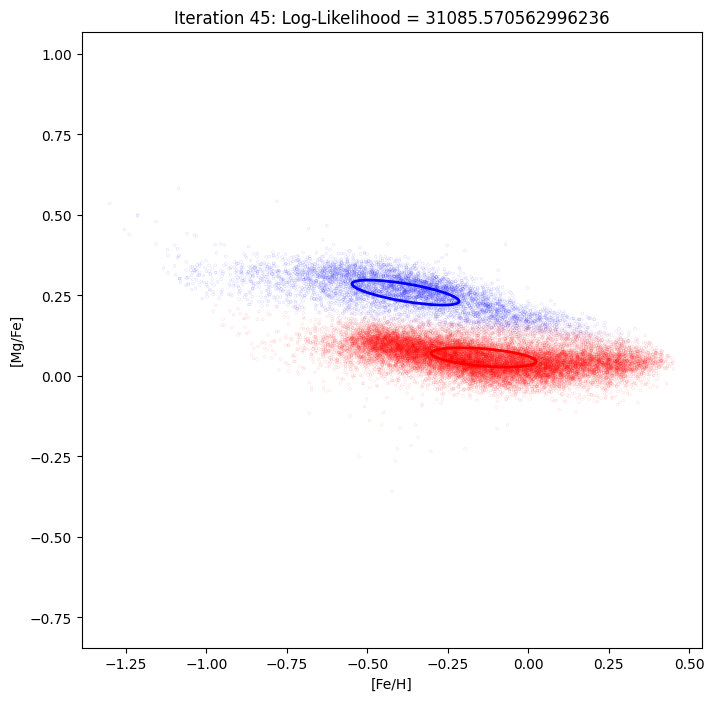

In [9]:
# Initialize parameters to some starting values (mu_0, Sigma_0, pi_0)
mu = mu_0
Sigma = Sigma_0
pi = pi_0

# Number of iterations for the EM algorithm
trials = 50

# Array to keep track of the log-likelihood values
ll = np.zeros(trials)

# Run the EM algorithm
for i in range(trials):
    # Compute the log-likelihood of the current model
    ll[i] = log_likelihood(data, mu, Sigma, pi)
    
    # Visualize the model every 5 iterations
    if i % 5 == 0:
        print(f"Iteration {i}: Current Log-Likelihood = {ll[i]}")
        
        # show the color 
        fig, ax = plot_data(redness = gamma[:,1])

        # Plot the Gaussian components
        plot_components(mu, Sigma, ['b', 'r'], 0.2, ax=ax)
        
        # Add a title to indicate the current iteration and log-likelihood
        plt.title(f"Iteration {i}: Log-Likelihood = {ll[i]}")
        plt.show()
        
    # Perform the E-step to update responsibilities
    gamma = e_step(data, mu, Sigma, pi)
    
    # Perform the M-step to update parameters
    mu, Sigma, pi = m_step(data, gamma)


## Summary: Gaussian Mixture Models with Expectation-Maximization

This tutorial provides a comprehensive walkthrough on how to implement and optimize Gaussian Mixture Models using the Expectation-Maximization (EM) algorithm. The tutorial covers the core concepts, mathematical foundations, and Python implementations for optimizing the GMM parameters.

#### Key Topics Covered

1. **Introduction to GMM**: An overview of Gaussian Mixture Models and their applications.
   
2. **Mathematical Background**: A review of the mathematical foundations, including the role of Expectation and Maximization steps in GMM.
   
3. **Parameter Estimation**: Discussion on how to perform maximum likelihood estimation for the GMM parameters $\mathbf{\mu}$, $\mathbf{\Sigma}$, and $\mathbf{\pi}$.

4. **Python Implementation**: Practical Python code for implementing the E-step and M-step functions, and a helper function for weighted normals.

5. **Log-Likelihood Evaluation**: A Python function to calculate the log-likelihood of the model, which is crucial for understanding model convergence.

6. **Convergence Visualization**: Graphs plotting the log-likelihood against the number of EM algorithm iterations, helping to understand if and when the algorithm converges.

7. **Model Visualization**: Code snippets for visualizing how the GMM adapts over time with the EM updates, providing intuitive insight into the model's learning process.


